Question 1:

Based only on the very first prompt of a session, can we predict whether the user will ask at least one follow-up question?

In [1]:
from datasets import load_from_disk

ds = load_from_disk("wildchat_local")
train_ds = ds["train"]

train_ds

Dataset({
    features: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header'],
    num_rows: 837989
})

In [4]:
import pandas as pd
import re
import numpy as np

In [2]:
def get_first_user_prompt(example):
    conv = example["conversation"]
    first_user = None
    
    for msg in conv:
        if msg.get("role") == "user":
            first_user = msg.get("content")
            break
    
    return {
        "first_prompt": first_user,
        "language": example.get("language"),
        "turn": example.get("turn"),
        "is_multiturn": 1 if (example.get("turn") is not None and example["turn"] > 1) else 0
    }

# Create a lighter dataset with just the needed columns
mini_ds = train_ds.map(get_first_user_prompt)

# Filter: keep only rows where first_prompt exists + English only (simple & clean)
mini_ds = mini_ds.filter(lambda x: x["first_prompt"] is not None and x["language"] == "English")
mini_ds

Map:   0%|          | 0/837989 [00:00<?, ? examples/s]

Filter:   0%|          | 0/837989 [00:00<?, ? examples/s]

Dataset({
    features: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header', 'first_prompt', 'is_multiturn'],
    num_rows: 478498
})

In [5]:
def clean_text(text: str) -> str:
    text = text.strip()
    text = re.sub(r"\s+", " ", text)             # collapse whitespace
    text = re.sub(r"http\S+|www\.\S+", "", text) # remove URLs
    return text.strip()

mini_df = mini_ds.to_pandas()
mini_df["first_prompt_clean"] = mini_df["first_prompt"].astype(str).apply(clean_text)

# Remove very short prompts (often noise)
mini_df = mini_df[mini_df["first_prompt_clean"].str.len() >= 10].copy()

mini_df.head()

,conversation_hash,model,timestamp,conversation,turn,language,openai_moderation,detoxify_moderation,toxic,redacted,state,country,hashed_ip,header,first_prompt,is_multiturn,first_prompt_clean
0,c9ec5b440fbdd2a269333dd241f32f64,gpt-4-0314,2023-04-09 00:02:53+00:00,[{'content': 'Hey there! Are you familiar with...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.00020589135237969458, '...",False,False,Texas,United States,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,"{'accept-language': 'en-US,en;q=0.9,es;q=0.8',...",Hey there! Are you familiar with reality shift...,0,Hey there! Are you familiar with reality shift...
1,cf1267ca6b2f6fccc9c36652a00059a1,gpt-4-0314,2023-04-09 00:04:52+00:00,"[{'content': 'Old age PT hx of DM, HTN, dyslip...",1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.0002258022577734664, 'i...",False,False,Mecca Region,Saudi Arabia,8133108d1c433c180c6be8302dc5a6681f2bec980190a1...,"{'accept-language': 'en-US,en;q=0.9', 'user-ag...","Old age PT hx of DM, HTN, dyslipidemia His ECG...",0,"Old age PT hx of DM, HTN, dyslipidemia His ECG..."
2,e98d3e74c57f9a65261df393d9124ac2,gpt-4-0314,2023-04-09 00:06:49+00:00,[{'content': 'Hey there! Are you familiar with...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.00020642601884901524, '...",False,False,Texas,United States,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,"{'accept-language': 'en-US,en;q=0.9,es;q=0.8',...",Hey there! Are you familiar with reality shift...,0,Hey there! Are you familiar with reality shift...
3,2e8fd255aab694b07a0be8d83cb53a7b,gpt-4-0314,2023-04-09 00:08:41+00:00,[{'content': 'Hey there! Are you familiar with...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.00020836590556427836, '...",False,False,Texas,United States,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,"{'accept-language': 'en-US,en;q=0.9,es;q=0.8',...",Hey there! Are you familiar with reality shift...,0,Hey there! Are you familiar with reality shift...
4,59c72510f3143025f94f75b883b026bd,gpt-3.5-turbo-0301,2023-04-09 00:10:00+00:00,[{'content': 'i wanna you to write me terms & ...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.0007317529525607824, 'i...",False,False,Giza,Egypt,dbf18c49cf217bc344a40b187ed35c3219f994b1d3b2d0...,"{'accept-language': 'en-US,en;q=0.9', 'user-ag...",i wanna you to write me terms & conditions and...,0,i wanna you to write me terms & conditions and...


In [6]:
KEYWORDS = ["explain", "how", "why", "help", "steps", "guide", "example", "difference", "compare"]

def make_features(text: str) -> dict:
    t = text.lower()
    return {
        "ends_with_qmark": int(t.endswith("?")),
        "has_explain": int("explain" in t),
        "has_how": int("how" in t),
        "has_why": int("why" in t),
        "has_question_word": int(any(w in t for w in ["how", "why", "what", "which", "when", "where"])),
        "num_words": len(t.split()),
        "num_chars": len(t),
        "has_keyword_any": int(any(k in t for k in KEYWORDS))
    }

feat_df = mini_df["first_prompt_clean"].apply(make_features).apply(pd.Series)

final_df = pd.concat(
    [mini_df[["first_prompt_clean", "turn", "is_multiturn"]].reset_index(drop=True),
     feat_df.reset_index(drop=True)],
    axis=1
)

final_df.head()

,first_prompt_clean,turn,is_multiturn,ends_with_qmark,has_explain,has_how,has_why,has_question_word,num_words,num_chars,has_keyword_any
0,Hey there! Are you familiar with reality shift...,1,0,0,0,0,0,1,232,1373,1
1,"Old age PT hx of DM, HTN, dyslipidemia His ECG...",1,0,1,0,0,0,1,22,113,0
2,Hey there! Are you familiar with reality shift...,1,0,0,0,0,0,1,240,1428,1
3,Hey there! Are you familiar with reality shift...,1,0,0,0,0,0,1,263,1568,1
4,i wanna you to write me terms & conditions and...,1,0,0,0,0,0,0,14,70,0


In [7]:
# Check class counts
print(final_df["is_multiturn"].value_counts())

# Balanced sampling (1250 from each class if possible)
n = 2500
n_per_class = n // 2

df0 = final_df[final_df["is_multiturn"] == 0]
df1 = final_df[final_df["is_multiturn"] == 1]

# In case one class has fewer than needed, sample as many as possible
n0 = min(n_per_class, len(df0))
n1 = min(n_per_class, len(df1))

sampled_df = pd.concat([
    df0.sample(n=n0, random_state=42),
    df1.sample(n=n1, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(sampled_df.shape)
sampled_df["is_multiturn"].value_counts()

is_multiturn
0    318765
1    148597
Name: count, dtype: int64
(2500, 11)


is_multiturn
1    1250
0    1250
Name: count, dtype: int64

In [8]:
sampled_df.to_csv("wildchat_multiturn_2500.csv", index=False)
print("Saved: wildchat_multiturn_2500.csv")

Saved: wildchat_multiturn_2500.csv


In [9]:
import pandas as pd

df = pd.read_csv("wildchat_multiturn_2500.csv")
df.head()


,first_prompt_clean,turn,is_multiturn,ends_with_qmark,has_explain,has_how,has_why,has_question_word,num_words,num_chars,has_keyword_any
0,Write me an email. My customer need a 5 pax of...,8,1,0,0,0,0,0,53,255,0
1,Ritsuka Fujimaru (casual shorts) and Mordred P...,1,0,0,0,0,0,0,33,250,0
2,"Please correct the grammar:Hello Egay, I made ...",1,0,0,0,0,0,0,35,226,0
3,invst 2000 usf bjkas in 2016 march today hlw m...,2,1,0,0,0,0,0,11,54,0
4,"Can you break down ""κέρατα Ἅιδου""?",4,1,1,0,0,0,0,6,34,0


In [10]:
df.shape


(2500, 11)

In [11]:
# Target
y = df["is_multiturn"]

# Feature columns (everything numeric, excluding text)
feature_cols = [
    "ends_with_qmark",
    "has_explain",
    "has_how",
    "has_why",
    "has_question_word",
    "has_keyword_any",
    "num_words",
    "num_chars"
]

X = df[feature_cols]

X.head()


,ends_with_qmark,has_explain,has_how,has_why,has_question_word,has_keyword_any,num_words,num_chars
0,0,0,0,0,0,0,53,255
1,0,0,0,0,0,0,33,250
2,0,0,0,0,0,0,35,226
3,0,0,0,0,0,0,11,54
4,1,0,0,0,0,0,6,34


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y  # important for class balance
)

X_train.shape, X_test.shape


((1875, 8), (625, 8))

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"  # important for imbalance
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [14]:
y_pred = rf.predict(X_test)


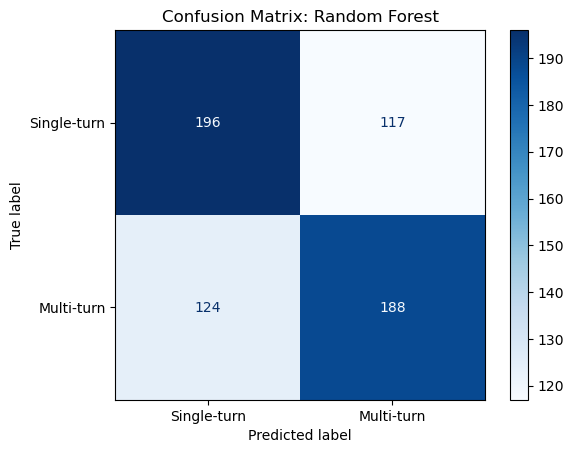

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Single-turn", "Multi-turn"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Random Forest")
plt.show()


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

           0      0.613     0.626     0.619       313
           1      0.616     0.603     0.609       312

    accuracy                          0.614       625
   macro avg      0.614     0.614     0.614       625
weighted avg      0.614     0.614     0.614       625



Question 2:

Can we predict the length of a chatbot's response (word count) based on the length of the user's initial prompt?

In [9]:
from datasets import load_from_disk
import pandas as pd
import numpy as np

dataset = load_from_disk("wildchat_local")
train_ds = dataset["train"]

In [10]:
def extract_prompt_response(example):
    conv = example["conversation"]
    
    user_prompt = None
    assistant_response = None
    
    for msg in conv:
        if msg.get("role") == "user" and user_prompt is None:
            user_prompt = msg.get("content")
        elif msg.get("role") == "assistant" and user_prompt is not None:
            assistant_response = msg.get("content")
            break

    return {
        "user_prompt": user_prompt,
        "assistant_response": assistant_response
    }

pr_ds = train_ds.map(extract_prompt_response)
pr_ds

Dataset({
    features: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header', 'user_prompt', 'assistant_response'],
    num_rows: 837989
})

In [ ]:
# Keep only valid prompt–response pairs
pr_ds = pr_ds.filter(
    lambda x: x["user_prompt"] is not None and x["assistant_response"] is not None
)
pr_ds


Filter:   0%|          | 0/837989 [00:00<?, ? examples/s]

Dataset({
    features: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header', 'user_prompt', 'assistant_response'],
    num_rows: 837989
})

In [12]:
def add_length_features(example):
    return {
        "user_prompt_len_words": len(example["user_prompt"].split()),
        "response_len_words": len(example["assistant_response"].split()),
        "user_prompt_len_chars": len(example["user_prompt"]),
        "response_len_chars": len(example["assistant_response"])
    }

pr_ds = pr_ds.map(add_length_features)
pr_ds



Map:   0%|          | 0/837989 [00:00<?, ? examples/s]

Dataset({
    features: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header', 'user_prompt', 'assistant_response', 'user_prompt_len_words', 'response_len_words', 'user_prompt_len_chars', 'response_len_chars'],
    num_rows: 837989
})

In [14]:
import numpy as np

# Take a small subset to estimate percentiles
subset = pr_ds.select(range(50000))

prompt_lens = [x["user_prompt_len_words"] for x in subset]
response_lens = [x["response_len_words"] for x in subset]

p_low, p_high = np.percentile(prompt_lens, [1, 99])
r_low, r_high = np.percentile(response_lens, [1, 99])

p_low, p_high, r_low, r_high


(np.float64(1.0), np.float64(1648.0), np.float64(1.0), np.float64(882.0))

In [ ]:
pr_ds = pr_ds.filter(
    lambda x: (
        p_low <= x["user_prompt_len_words"] <= p_high and
        r_low <= x["response_len_words"] <= r_high
    )
)

pr_ds

Filter:   0%|          | 0/837989 [00:00<?, ? examples/s]

Dataset({
    features: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header', 'user_prompt', 'assistant_response', 'user_prompt_len_words', 'response_len_words', 'user_prompt_len_chars', 'response_len_chars'],
    num_rows: 811950
})

In [16]:
pr_ds = pr_ds.remove_columns(
    [
        col for col in pr_ds.column_names
        if col not in [
            "user_prompt_len_words",
            "response_len_words",
            "user_prompt_len_chars",
            "response_len_chars"
        ]
    ]
)

pr_ds

Dataset({
    features: ['user_prompt_len_words', 'response_len_words', 'user_prompt_len_chars', 'response_len_chars'],
    num_rows: 811950
})

In [ ]:
regression_ds = pr_ds.shuffle(seed=42).select(range(3000))
regression_ds

Dataset({
    features: ['user_prompt_len_words', 'response_len_words', 'user_prompt_len_chars', 'response_len_chars'],
    num_rows: 3000
})

In [ ]:
regression_df = regression_ds.to_pandas()
regression_df.describe()

,user_prompt_len_words,response_len_words,user_prompt_len_chars,response_len_chars
count,3000.000000,3000.000000,3000.000000,3000.000
mean,143.543667,204.985667,1075.632333,1400.121
std,268.652084,183.380207,2061.872642,1183.909
min,1.000000,1.000000,1.000000,4.000
25%,7.000000,37.000000,49.750000,369.000
50%,22.000000,168.000000,159.000000,1158.000
75%,137.250000,324.000000,891.250000,2150.000
max,1642.000000,873.000000,18335.000000,8845.000


In [20]:
regression_df.to_csv(
    "wildchat_response_length_regression.csv",
    index=False
)

print("Saved: wildchat_response_length_regression.csv")


Saved: wildchat_response_length_regression.csv


In [21]:
import pandas as pd

df = pd.read_csv("wildchat_response_length_regression.csv")
df.head()


,user_prompt_len_words,response_len_words,user_prompt_len_chars,response_len_chars
0,1,12,20,379
1,12,575,91,3629
2,39,20,206,133
3,120,371,899,3100
4,1,20,70,436


In [23]:
df = df.dropna(subset=["user_prompt_len_words", "response_len_words"])

# Remove extreme outliers (important for linear regression)
df = df[
    (df["user_prompt_len_words"] < 500) &
    (df["response_len_words"] < 1000)
]

df.shape


(2833, 4)

In [24]:
from sklearn.model_selection import train_test_split

X = df[["user_prompt_len_words"]]
y = df["response_len_words"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)


In [25]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [26]:
y_pred = lr.predict(X_test)


In [27]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.3f}")


MSE: 27080.33
R² Score: 0.145


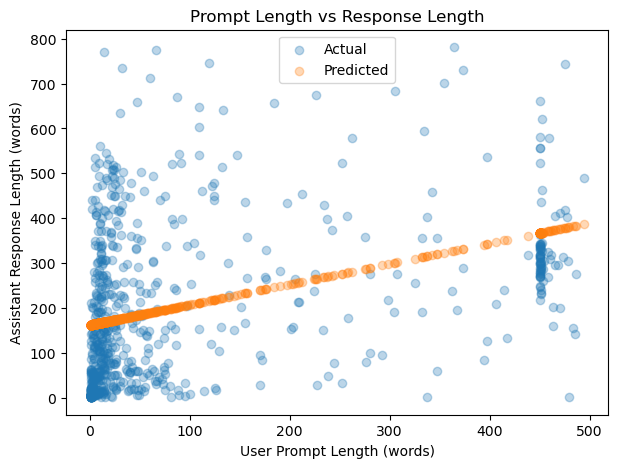

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(X_test, y_test, alpha=0.3, label="Actual")
plt.scatter(X_test, y_pred, alpha=0.3, label="Predicted")
plt.xlabel("User Prompt Length (words)")
plt.ylabel("Assistant Response Length (words)")
plt.title("Prompt Length vs Response Length")
plt.legend()
plt.show()
